# ML Projekt SS25 Gruppe 256378

## Mitglieder 
(Soll das noch raus? Kommt eigentlich in dem Email Body, mehr als Platzhalter hier)

### Namen: David Sprengart, Florian Hertel, Lars Hoffmann
### RZ-Kürzel: spda1019, hefl1025, hola1017
### Studiengang: INFB, INFB, INFB

## Aufgabe

### 0. Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

### 1. Laden Sie die Trainingsdaten.

In [2]:
train_df = pd.read_csv("./data/train.csv", delimiter =';')
train_df

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0
...,...,...,...,...,...
22395,5461363334,"[4, 5, 4]",new,147.0,0
22396,9013779310,"[3, 4, 4, 4, 0]",NaN,NaN,1
22397,1590423615,"[0, 4, 3]",new,249.0,1
22398,1800993941,"[0, 5, 1, 2, 5, 5, 4, 4]",existing,80.0,0


### 2. Führen Sie eine kurze EDA durch

#### Plotten Sie Histogramme zu den Features customerType und totalAmount

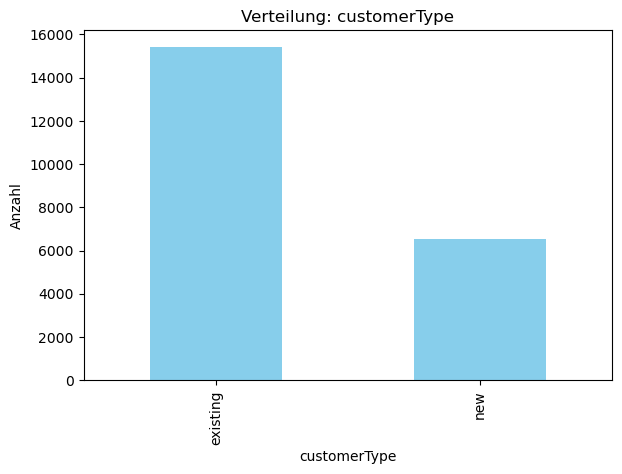

In [3]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
train_df['customerType'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Verteilung: customerType")
plt.xlabel("customerType")
plt.ylabel("Anzahl")
plt.show()

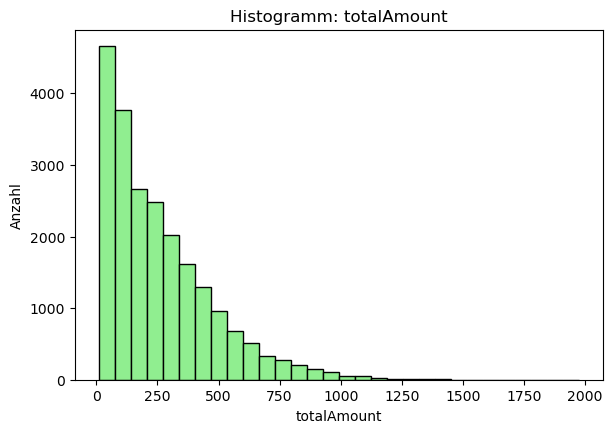

In [4]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 2)
plt.hist(train_df['totalAmount'], bins=30, color='lightgreen', edgecolor='black')
plt.title("Histogramm: totalAmount")
plt.xlabel("totalAmount")
plt.ylabel("Anzahl")
plt.show()

#### Ermitteln sie die Verteilung (Histogramm) von returnLabel i) über alle Daten ii) in Abhängigkeit zu allen Ausprägungen von customerType.

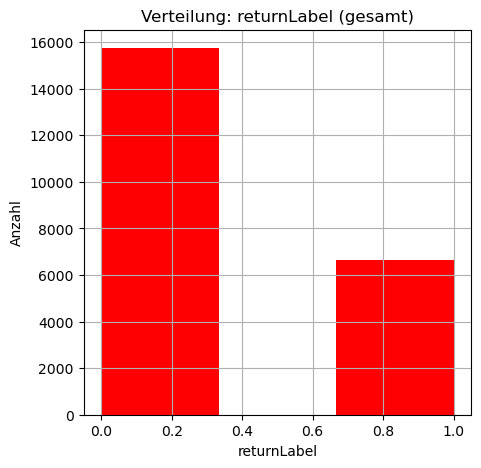

In [5]:
train_df['returnLabel'].hist(figsize=(5,5), bins = 3, color='red')
plt.title("Verteilung: returnLabel (gesamt)")
plt.xlabel("returnLabel")
plt.ylabel("Anzahl")
plt.show()

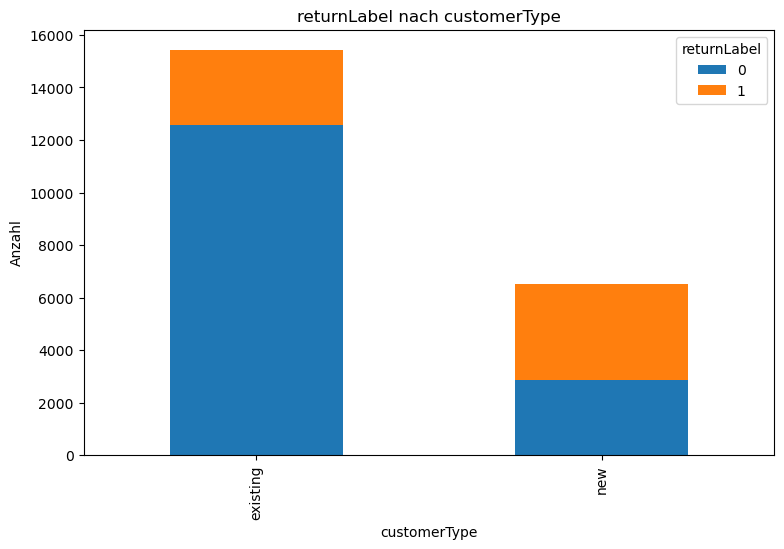

In [6]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 4)
pd.crosstab(train_df['customerType'], train_df['returnLabel']).plot(kind='bar', stacked=True, ax=plt.gca())
plt.title("returnLabel nach customerType")
plt.xlabel("customerType")
plt.ylabel("Anzahl")

plt.tight_layout()
plt.show()

#### Erstellen Sie einen Boxplot für totalAmount in Abhängigkeit des Labels (nutzen Sie dafür den Parameter by=…)

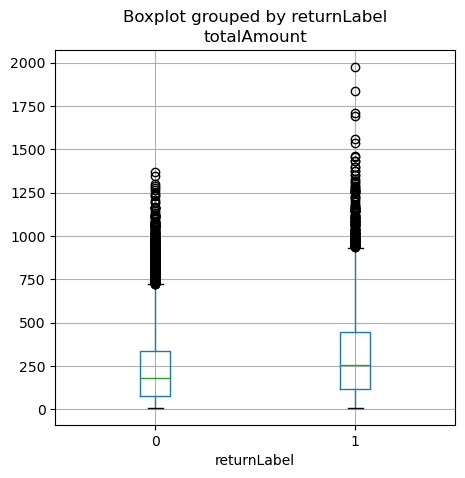

In [7]:
train_df.boxplot(column='totalAmount', by='returnLabel', figsize=(5,5))
plt.show()

#### Installieren Sie das Seaborn-Package und erstellen Sie einen displot für totalAmount in Abhängigkeit des Labels, wie [hier](https://seaborn.pydata.org/tutorial/distributions.html#conditioning-on-other-variables) beschrieben.

C:\Users\david\miniconda3\envs\ml-course\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


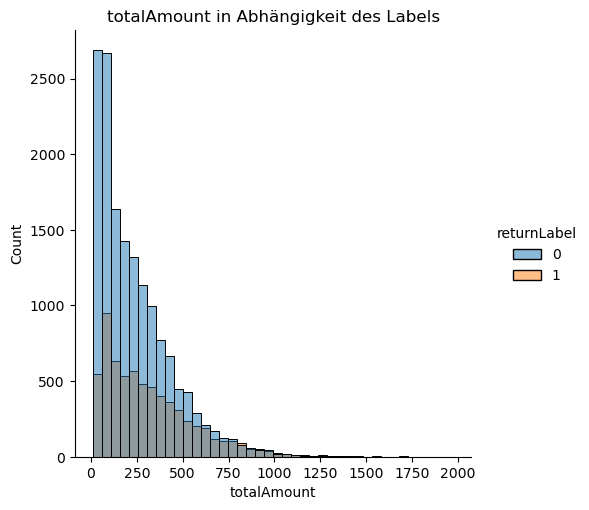

In [8]:
sns.displot(train_df, x="totalAmount", hue="returnLabel",  fill = "true", bins = 40)
plt.title("totalAmount in Abhängigkeit des Labels")
plt.show()
# TODO: Behebe Fehlermeldung? -> "Warten Sie bis alle Zellen fehlerfrei ausgeführt wurden"

### 3. Füllen Sie fehlende Werte in den Trainingsdaten auf.

In [9]:
train_df.isnull().sum()

transactionId      0
basket             0
customerType     442
totalAmount      477
returnLabel        0
dtype: int64

In [10]:
train_df['customerType'].fillna(train_df['customerType'].mode()[0], inplace = True)
train_df['totalAmount'].fillna(train_df['totalAmount'].mean(), inplace = True)
train_df.isnull().sum()

transactionId    0
basket           0
customerType     0
totalAmount      0
returnLabel      0
dtype: int64

### 4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.

In [11]:
train_df.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


In [12]:
train_df = pd.get_dummies(train_df, columns=["customerType"], dtype=int, drop_first=True)
train_df.head()

,transactionId,basket,totalAmount,returnLabel,customerType_new
0,9534310106,"[4, 3, 4]",252.0,1,1
1,7202594767,"[4, 2, 0, 2, 5]",70.0,0,0
2,2737331698,[5],84.0,0,0
3,4868011733,"[1, 4, 2, 4]",116.0,0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,0,0


### 5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft kommt jede Kategorie im Basket vor).

In [13]:
train_df['basket'] = train_df['basket'].apply(ast.literal_eval)
train_df['basket_counts'] = train_df['basket'].apply(lambda x: Counter(x))

for i in range(6):
    train_df[f'basket_cat_{i}'] = train_df['basket_counts'].apply(lambda c: c.get(i, 0))

train_df.drop(columns=['basket', 'basket_counts'], inplace=True)
train_df.head()

,transactionId,totalAmount,returnLabel,customerType_new,basket_cat_0,basket_cat_1,basket_cat_2,basket_cat_3,basket_cat_4,basket_cat_5
0,9534310106,252.0,1,1,0,0,0,1,2,0
1,7202594767,70.0,0,0,1,0,2,0,1,1
2,2737331698,84.0,0,0,0,0,0,0,0,1
3,4868011733,116.0,0,0,0,1,1,0,2,0
4,7622406570,378.0,0,0,1,0,3,2,0,1


### 6. Skalieren Sie die Features mit einem StandardScaler.

In [14]:
features_to_scale = ["totalAmount", "basket_cat_0", "basket_cat_1", "basket_cat_2", "basket_cat_3", "basket_cat_4", "basket_cat_5"]
scaler = StandardScaler()
train_df[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])
train_df.head()

,transactionId,totalAmount,returnLabel,customerType_new,basket_cat_0,basket_cat_1,basket_cat_2,basket_cat_3,basket_cat_4,basket_cat_5
0,9534310106,-0.032823,1,1,-0.771563,-0.767737,-0.775046,0.075189,0.634586,-0.644106
1,7202594767,-0.879459,0,0,0.383487,-0.767737,1.514422,-0.880132,-0.122402,0.527090
2,2737331698,-0.814334,0,0,-0.771563,-0.767737,-0.775046,-0.880132,-0.879391,0.527090
3,4868011733,-0.665475,0,0,-0.771563,0.391580,0.369688,-0.880132,0.634586,-0.644106
4,7622406570,0.553309,0,0,0.383487,-0.767737,2.659156,1.030510,-0.879391,0.527090


### 7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die angegebenen Hyperparameter mittels Cross-Validation aus

In [15]:
x_train = train_df.drop(columns=['returnLabel'])
y_train = train_df['returnLabel']

#### 1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]

In [16]:
parameter_lr = [{'C': [0.1, 1, 4, 5, 6, 10, 30, 100], 'penalty': ['l1', 'l2']}]

log = LogisticRegression(solver = 'liblinear', max_iter = 500)
grid_lr = GridSearchCV(estimator = log, param_grid = parameter_lr, n_jobs =- 1)
grid_lr.fit(x_train, y_train)
log_best_model = grid_lr.best_estimator_

C:\Users\david\miniconda3\envs\ml-course\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [17]:
print('Best C:', grid_lr.best_estimator_.C)
print('Best penalty:', grid_lr.best_estimator_.penalty)

Best C: 1
Best penalty: l1


#### 2. Random Forest: n_estimators: [60,80,100,120,140] und max_depth: [2, 4, 6]

In [18]:
parameter = [{'n_estimators': [60,80,100,120,140], 'max_depth': [2, 4, 6]}]

rf = RandomForestClassifier(random_state=0)
grid_rf = GridSearchCV(estimator=rf, param_grid=parameter, n_jobs=-1)
grid_rf.fit(x_train, y_train)
rf_bestModel = grid_rf.best_estimator_

In [19]:
print ('Best n_estimators:', grid_rf.best_estimator_.n_estimators)
print ('Best max_depth:', grid_rf.best_estimator_.max_depth)

Best n_estimators: 120
Best max_depth: 6


#### 3. Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

In [20]:
parameter = [{'n_estimators': [60,80,100,120,140], 'max_depth': [2, 4, 6]}]

gbt = GradientBoostingClassifier(random_state=0)
grid_gbt = GridSearchCV(estimator=gbt, param_grid=parameter, n_jobs=-1)
grid_gbt.fit(x_train, y_train)
gbt_bestModel = grid_gbt.best_estimator_

In [21]:
print('Best n_estimators:', grid_gbt.best_estimator_.n_estimators) 
print('Best max_depth:', grid_gbt.best_estimator_.max_depth)

Best n_estimators: 80
Best max_depth: 6


### 8. Laden Sie die Testdaten

In [22]:
test_df = pd.read_csv('data/test.csv', delimiter = ';')
test_df

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0
...,...,...,...,...,...
9595,7995301628,"[1, 3]",existing,66.0,0
9596,7387398375,"[1, 4, 3, 3]",existing,40.0,0
9597,2777556607,[4],existing,126.0,1
9598,7205276301,"[4, 5, 4, 1, 0, 2, 0]",existing,70.0,0


### 9. Entfernen Sie alle Zeilen mit fehlenden Werten.

In [23]:
test_df.isna().sum()

transactionId      0
basket             0
customerType     203
totalAmount      175
returnLabel        0
dtype: int64

In [24]:
test_df_NaN = test_df.dropna()
test_df_NaN

,transactionId,basket,customerType,totalAmount,returnLabel
0,4132523932,"[4, 3, 4, 3, 2, 3]",existing,366.0,1
1,8998574539,"[3, 4, 4, 3, 5]",existing,85.0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",existing,275.0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",existing,528.0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",existing,287.0,0
...,...,...,...,...,...
9595,7995301628,"[1, 3]",existing,66.0,0
9596,7387398375,"[1, 4, 3, 3]",existing,40.0,0
9597,2777556607,[4],existing,126.0,1
9598,7205276301,"[4, 5, 4, 1, 0, 2, 0]",existing,70.0,0


In [25]:
test_df_NaN.isna().sum()

transactionId    0
basket           0
customerType     0
totalAmount      0
returnLabel      0
dtype: int64

### 10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

In [26]:
test_df = pd.get_dummies(test_df_NaN, columns=["customerType"], dtype=int, drop_first=True)
test_df.head()

,transactionId,basket,totalAmount,returnLabel,customerType_new
0,4132523932,"[4, 3, 4, 3, 2, 3]",366.0,1,0
1,8998574539,"[3, 4, 4, 3, 5]",85.0,0,0
2,9346688547,"[1, 1, 2, 2, 4, 4, 3, 1, 1, 0, 3]",275.0,0,0
3,4533897707,"[3, 2, 2, 1, 5, 1, 1, 0]",528.0,0,0
4,3334800500,"[4, 2, 3, 5, 2, 5, 1]",287.0,0,0


In [27]:
test_df['basket'] = test_df['basket'].apply(ast.literal_eval)
test_df['basket_counts'] = test_df['basket'].apply(lambda x: Counter(x))

for i in range(6):
    test_df[f'basket_cat_{i}'] = test_df['basket_counts'].apply(lambda c: c.get(i, 0))

test_df.drop(columns=['basket', 'basket_counts'], inplace=True)
test_df.head()

,transactionId,totalAmount,returnLabel,customerType_new,basket_cat_0,basket_cat_1,basket_cat_2,basket_cat_3,basket_cat_4,basket_cat_5
0,4132523932,366.0,1,0,0,0,1,3,2,0
1,8998574539,85.0,0,0,0,0,0,2,2,1
2,9346688547,275.0,0,0,1,4,2,2,2,0
3,4533897707,528.0,0,0,1,3,2,1,0,1
4,3334800500,287.0,0,0,0,1,2,1,1,2


### 11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten.

In [28]:
features_to_scale = ["totalAmount", "basket_cat_0", "basket_cat_1", "basket_cat_2", "basket_cat_3", "basket_cat_4", "basket_cat_5"]
scaler = StandardScaler()
test_df[features_to_scale] = scaler.fit_transform(test_df[features_to_scale])
test_df.head()

,transactionId,totalAmount,returnLabel,customerType_new,basket_cat_0,basket_cat_1,basket_cat_2,basket_cat_3,basket_cat_4,basket_cat_5
0,4132523932,0.462354,1,0,-0.777495,-0.784618,0.392539,1.988715,0.623829,-0.652663
1,8998574539,-0.800293,0,0,-0.777495,-0.784618,-0.771951,1.032747,0.623829,0.525246
2,9346688547,0.053454,0,0,0.387927,3.847529,1.557029,1.032747,0.623829,-0.652663
3,4533897707,1.190286,0,0,0.387927,2.689492,1.557029,0.076780,-0.875570,0.525246
4,3334800500,0.107375,0,0,-0.777495,0.373419,1.557029,0.076780,-0.125871,1.703155


### 12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den jeweils besten Hyperparametern aus der Cross Validation.

In [29]:
x_test = test_df.drop(columns=['returnLabel'])
y_test = test_df['returnLabel']

#### 1. Logistische Regression

In [30]:
y_pred_log = log_best_model.predict(x_test)